# Cuaderno 03: Entrenamiento de la Vía Visual (Grafema -> Secuencia de Embeddings)

**Objetivo:** Entrenar un modelo capaz de predecir la secuencia completa de embeddings auditivos (`wav2vec2`) a partir de una única imagen de su grafema correspondiente (letra de EMNIST).

**Flujo de Trabajo:**
1.  **Instalación y Configuración**: Instalar `cornet` y definir los parámetros globales.
2.  **Preparación de Datos**: Crear un `Dataset` que empareje cada imagen de EMNIST con su secuencia de embedding auditivo correspondiente. Esto incluye una función `collate_fn` para manejar el padding.
3.  **Definición del Modelo**: Construir el modelo híbrido `CORNet-Z (congelado) + Decodificador LSTM (entrenable)`.
4.  **Bucle Principal de Entrenamiento**: Entrenar y evaluar el modelo para español e inglés en una sola ejecución.
5.  **Análisis Comparativo**: Visualizar la pérdida y la similitud coseno para comparar el rendimiento entre idiomas.

In [1]:
%pip install cornet --quiet
%gui qt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cornet.cornet_z import CORnet_Z
from tqdm.auto import tqdm
import os
import torch.nn.functional as F

# --- Parámetros Globales ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "cornetZ_lstm_decoder_v1"
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.002
VALIDATION_SPLIT = 0.1

# --- Rutas ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Diccionario para almacenar todos los resultados
results_visual = {}

## Paso 1: Definición del Dataset y el Modelo

Definimos las clases para nuestro `Dataset` personalizado y el modelo `VisualToAuditoryModel`.

-   **`GraphemeDataset`**: Se encarga de cargar una imagen de una letra y su correspondiente secuencia de embedding auditivo. Filtra para usar solo los grafemas que existen en ambos dominios (visual y auditivo).
-   **`VisualToAuditoryModel`**: Contiene la arquitectura CORNet-Z + Decodificador LSTM.

In [3]:
# --- Importaciones Necesarias para esta Celda ---
from collections import OrderedDict
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
# La clase CORnet_Z está en el módulo cornet_z.py
from cornet.cornet_z import CORnet_Z

# --- Definición del Dataset (sin cambios) ---
class GraphemeDataset(Dataset):
    def __init__(self, image_dir, embedding_dir, transform=None):
        self.transform = transform
        self.embedding_dir = embedding_dir
        image_graphemes = {p.parent.name for p in image_dir.glob("*/*.png")}
        embedding_graphemes = {p.stem for p in embedding_dir.glob("*.npy")}
        common_graphemes = sorted(list(image_graphemes.intersection(embedding_graphemes)))
        self.image_paths = []
        for grapheme in common_graphemes:
            self.image_paths.extend(list((image_dir / grapheme).glob("*.png")))
        print(f"Dataset creado con {len(self.image_paths)} imágenes de {len(common_graphemes)} grafemas comunes.")
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = img_path.parent.name
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        embedding_path = self.embedding_dir / f"{label}.npy"
        embedding = torch.tensor(np.load(embedding_path), dtype=torch.float32)
        return image, embedding, label

# --- Definición del Modelo (con la carga de CORNet corregida) ---
class VisualToAuditoryModel(nn.Module):
    def __init__(self, target_embedding_dim=1024, lstm_hidden_dim=512, dropout=0.3):
        super().__init__()
        
        # 1. Creamos una instancia del modelo CORnet-Z
        self.cornet = CORnet_Z()
        
        # 2. Definimos la URL de los pesos pre-entrenados
        url = 'https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth'
        
        # 3. Cargamos los pesos desde la URL
        ckpt_data = torch.hub.load_state_dict_from_url(url, map_location="cpu")
        original_state_dict = ckpt_data['state_dict']

        # --- CORRECCIÓN DEFINITIVA: Limpiamos el prefijo 'module.' de las claves ---
        new_state_dict = OrderedDict()
        for k, v in original_state_dict.items():
            name = k[7:] if k.startswith('module.') else k # elimina el prefijo `module.`
            new_state_dict[name] = v
        # --------------------------------------------------------------------------

        # 4. Cargamos el state_dict ya limpio en nuestro modelo
        self.cornet.load_state_dict(new_state_dict)
        
        cornet_output_dim = self.cornet.decoder.linear.in_features
        self.cornet.decoder.linear = nn.Identity()
        for param in self.cornet.parameters():
            param.requires_grad = False
            
        self.projector = nn.Sequential(nn.Linear(cornet_output_dim, lstm_hidden_dim), nn.BatchNorm1d(lstm_hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.decoder_lstm = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(lstm_hidden_dim, target_embedding_dim)

    def forward(self, image, target_sequence):
        seq_len = target_sequence.shape[1]
        cornet_features = self.cornet(image)
        projected_features = self.projector(cornet_features)
        h0 = projected_features.unsqueeze(0).repeat(self.decoder_lstm.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        decoder_input = projected_features.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        predicted_sequence = self.output_layer(lstm_output)
        return predicted_sequence

## Paso 2: Bucle Principal de Procesamiento y Entrenamiento

Este bucle itera sobre cada idioma para entrenar y evaluar el modelo `VisualToAuditoryModel`. Incluye una `collate_fn` personalizada para manejar el padding tanto de las imágenes (si fuera necesario) como de las secuencias de embeddings.

In [4]:
# Definir las transformaciones para las imágenes de EMNIST
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- CORRECCIÓN: Cambiamos la función de pérdida a MSELoss ---
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn_visual(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings

for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    # --- 1. Crear Datasets y DataLoaders ---
    image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    
    full_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform)
    
    val_size = int(VALIDATION_SPLIT * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_visual)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)

    # --- 2. Instanciar y Entrenar el Modelo ---
    model = VisualToAuditoryModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_loss': [], 'val_euclidean_dist': []}

    print(f"Entrenando modelo para '{lang}' con {len(train_dataset)} imágenes de entrenamiento...")
    for epoch in tqdm(range(EPOCHS), desc=f'Training {lang.upper()}'):
        model.train()
        running_loss = 0.0
        for images, target_embeddings in train_loader:
            images, target_embeddings = images.to(device), target_embeddings.to(device)
            optimizer.zero_grad()
            predicted_embeddings = model(images, target_embeddings)
            
            # --- CORRECCIÓN: Se elimina el tercer argumento de la función de pérdida ---
            loss = loss_fn(
                predicted_embeddings.flatten(0, 1),
                target_embeddings.flatten(0, 1)
            )
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        history['train_loss'].append(running_loss / len(train_loader))

        # Validación
        model.eval()
        running_val_loss = 0.0
        running_distance = 0.0
        with torch.no_grad():
            for images, target_embeddings in val_loader:
                images, target_embeddings = images.to(device), target_embeddings.to(device)
                predicted_embeddings = model(images, target_embeddings)
                
                # --- CORRECCIÓN: Se elimina el tercer argumento también aquí ---
                loss = loss_fn(
                    predicted_embeddings.flatten(0, 1),
                    target_embeddings.flatten(0, 1)
                )
                running_val_loss += loss.item()
                
                dist = F.pairwise_distance(
                    predicted_embeddings.mean(dim=1),
                    target_embeddings.mean(dim=1),
                    p=2
                ).mean()
                running_distance += dist.item()

        history['val_loss'].append(running_val_loss / len(val_loader))
        history['val_euclidean_dist'].append(running_distance / len(val_loader))
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Euclidean Dist: {history['val_euclidean_dist'][-1]:.4f}")

    results_visual[lang] = {'history': history, 'model': model, 'val_dataset': val_dataset}
    
print(f"\n{'='*20} PROCESO COMPLETADO {'='*20}")


==================== PROCESANDO IDIOMA: ES ====================
Dataset creado con 1150 imágenes de 23 grafemas comunes.
Entrenando modelo para 'es' con 1035 imágenes de entrenamiento...


Training ES:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10/200], Train Loss: 0.0013, Val Loss: 0.0018, Val Euclidean Dist: 0.3499
Epoch [20/200], Train Loss: 0.0011, Val Loss: 0.0018, Val Euclidean Dist: 0.3484
Epoch [30/200], Train Loss: 0.0008, Val Loss: 0.0014, Val Euclidean Dist: 0.2376
Epoch [40/200], Train Loss: 0.0008, Val Loss: 0.0016, Val Euclidean Dist: 0.2879
Epoch [50/200], Train Loss: 0.0008, Val Loss: 0.0014, Val Euclidean Dist: 0.2228
Epoch [60/200], Train Loss: 0.0007, Val Loss: 0.0014, Val Euclidean Dist: 0.2504
Epoch [70/200], Train Loss: 0.0006, Val Loss: 0.0013, Val Euclidean Dist: 0.2422
Epoch [80/200], Train Loss: 0.0007, Val Loss: 0.0016, Val Euclidean Dist: 0.2748
Epoch [90/200], Train Loss: 0.0010, Val Loss: 0.0017, Val Euclidean Dist: 0.3131
Epoch [100/200], Train Loss: 0.0005, Val Loss: 0.0014, Val Euclidean Dist: 0.2496
Epoch [110/200], Train Loss: 0.0005, Val Loss: 0.0013, Val Euclidean Dist: 0.2358
Epoch [120/200], Train Loss: 0.0004, Val Loss: 0.0015, Val Euclidean Dist: 0.2495
Epoch [130/200], Train Lo

Training EN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10/200], Train Loss: 0.0018, Val Loss: 0.0015, Val Euclidean Dist: 0.2241
Epoch [20/200], Train Loss: 0.0014, Val Loss: 0.0014, Val Euclidean Dist: 0.1693
Epoch [30/200], Train Loss: 0.0013, Val Loss: 0.0013, Val Euclidean Dist: 0.1568
Epoch [40/200], Train Loss: 0.0012, Val Loss: 0.0012, Val Euclidean Dist: 0.1322
Epoch [50/200], Train Loss: 0.0010, Val Loss: 0.0012, Val Euclidean Dist: 0.1393
Epoch [60/200], Train Loss: 0.0010, Val Loss: 0.0010, Val Euclidean Dist: 0.1356
Epoch [70/200], Train Loss: 0.0007, Val Loss: 0.0008, Val Euclidean Dist: 0.1079
Epoch [80/200], Train Loss: 0.0007, Val Loss: 0.0010, Val Euclidean Dist: 0.1216
Epoch [90/200], Train Loss: 0.0008, Val Loss: 0.0010, Val Euclidean Dist: 0.1548
Epoch [100/200], Train Loss: 0.0004, Val Loss: 0.0008, Val Euclidean Dist: 0.1058
Epoch [110/200], Train Loss: 0.0003, Val Loss: 0.0009, Val Euclidean Dist: 0.1185
Epoch [120/200], Train Loss: 0.0004, Val Loss: 0.0010, Val Euclidean Dist: 0.1262
Epoch [130/200], Train Lo

## Paso 3: Visualizaciones Comparativas y Guardado

Una vez entrenados los modelos, comparamos sus curvas de aprendizaje y su rendimiento final en la métrica de similitud coseno.

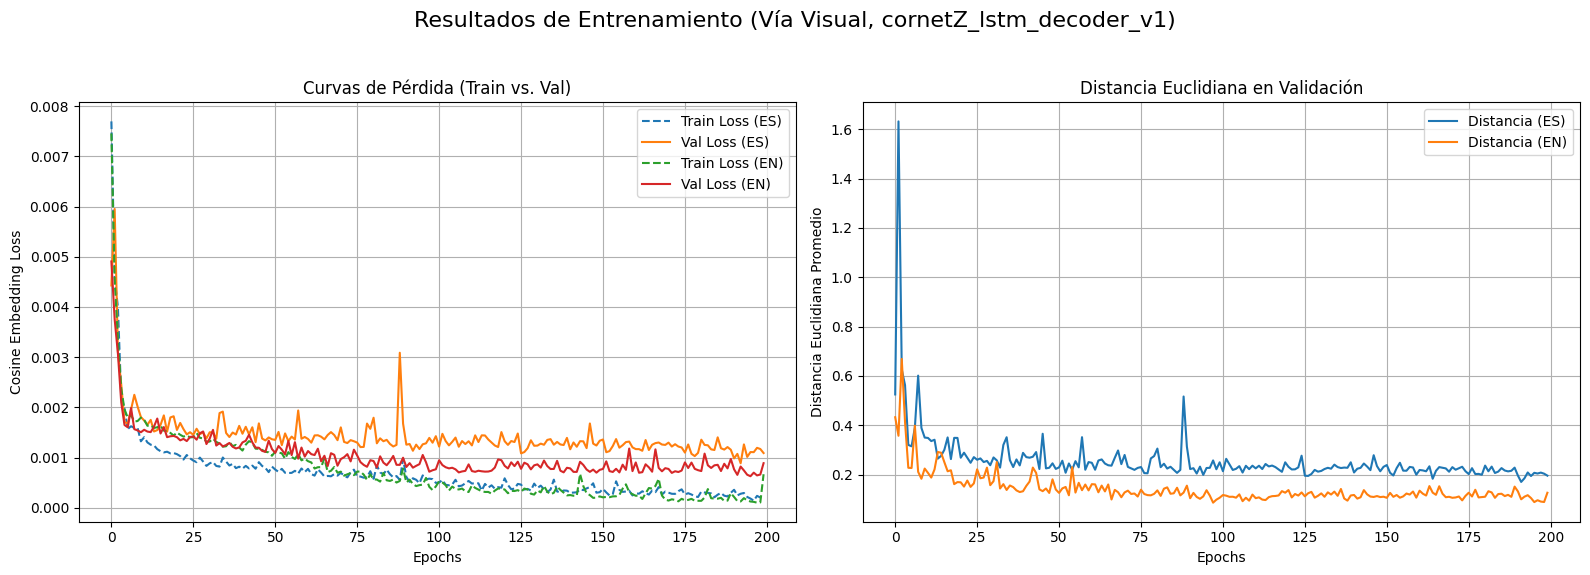

Curvas de aprendizaje guardadas en: /home/daniel/Proyectos/phonological-awareness/results/figures/comparative_visual_cornetZ_lstm_decoder_v1_learning_curves.png
Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_cornetZ_lstm_decoder_v1.pth
Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_cornetZ_lstm_decoder_v1.pth


In [5]:
# --- Guardar Curvas de Aprendizaje ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Pérdida
for lang in LANGUAGES:
    ax1.plot(results_visual[lang]['history']['train_loss'], label=f'Train Loss ({lang.upper()})', linestyle='--')
    ax1.plot(results_visual[lang]['history']['val_loss'], label=f'Val Loss ({lang.upper()})')
ax1.set_title('Curvas de Pérdida (Train vs. Val)')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Cosine Embedding Loss'); ax1.legend(); ax1.grid(True)

# --- Gráfico de Distancia Euclidiana (MODIFICADO) ---
for lang in LANGUAGES:
    # Usamos la nueva métrica guardada en el historial
    ax2.plot(results_visual[lang]['history']['val_euclidean_dist'], label=f'Distancia ({lang.upper()})')
ax2.set_title('Distancia Euclidiana en Validación')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Distancia Euclidiana Promedio'); ax2.legend(); ax2.grid(True)

fig.suptitle(f'Resultados de Entrenamiento (Vía Visual, {MODEL_ARCHITECTURE})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Guardar la figura
visual_learning_curves_path = figure_dir / f"comparative_visual_{MODEL_ARCHITECTURE}_learning_curves.png"
plt.savefig(visual_learning_curves_path)
plt.show()
print(f"Curvas de aprendizaje guardadas en: {visual_learning_curves_path}")

# --- Guardar los modelos entrenados ---
for lang in LANGUAGES:
    model_visual = results_visual[lang]['model']
    model_visual_path = model_dir / f"{lang}_visual_{MODEL_ARCHITECTURE}.pth"
    torch.save(model_visual.state_dict(), model_visual_path)
    print(f"Modelo para '{lang}' guardado en: {model_visual_path}")

Preparando datos para la visualización t-SNE comparativa...
Dataset creado con 1150 imágenes de 23 grafemas comunes.
Dataset creado con 1200 imágenes de 24 grafemas comunes.

Calculando proyección t-SNE para todos los embeddings... Esto puede tardar.


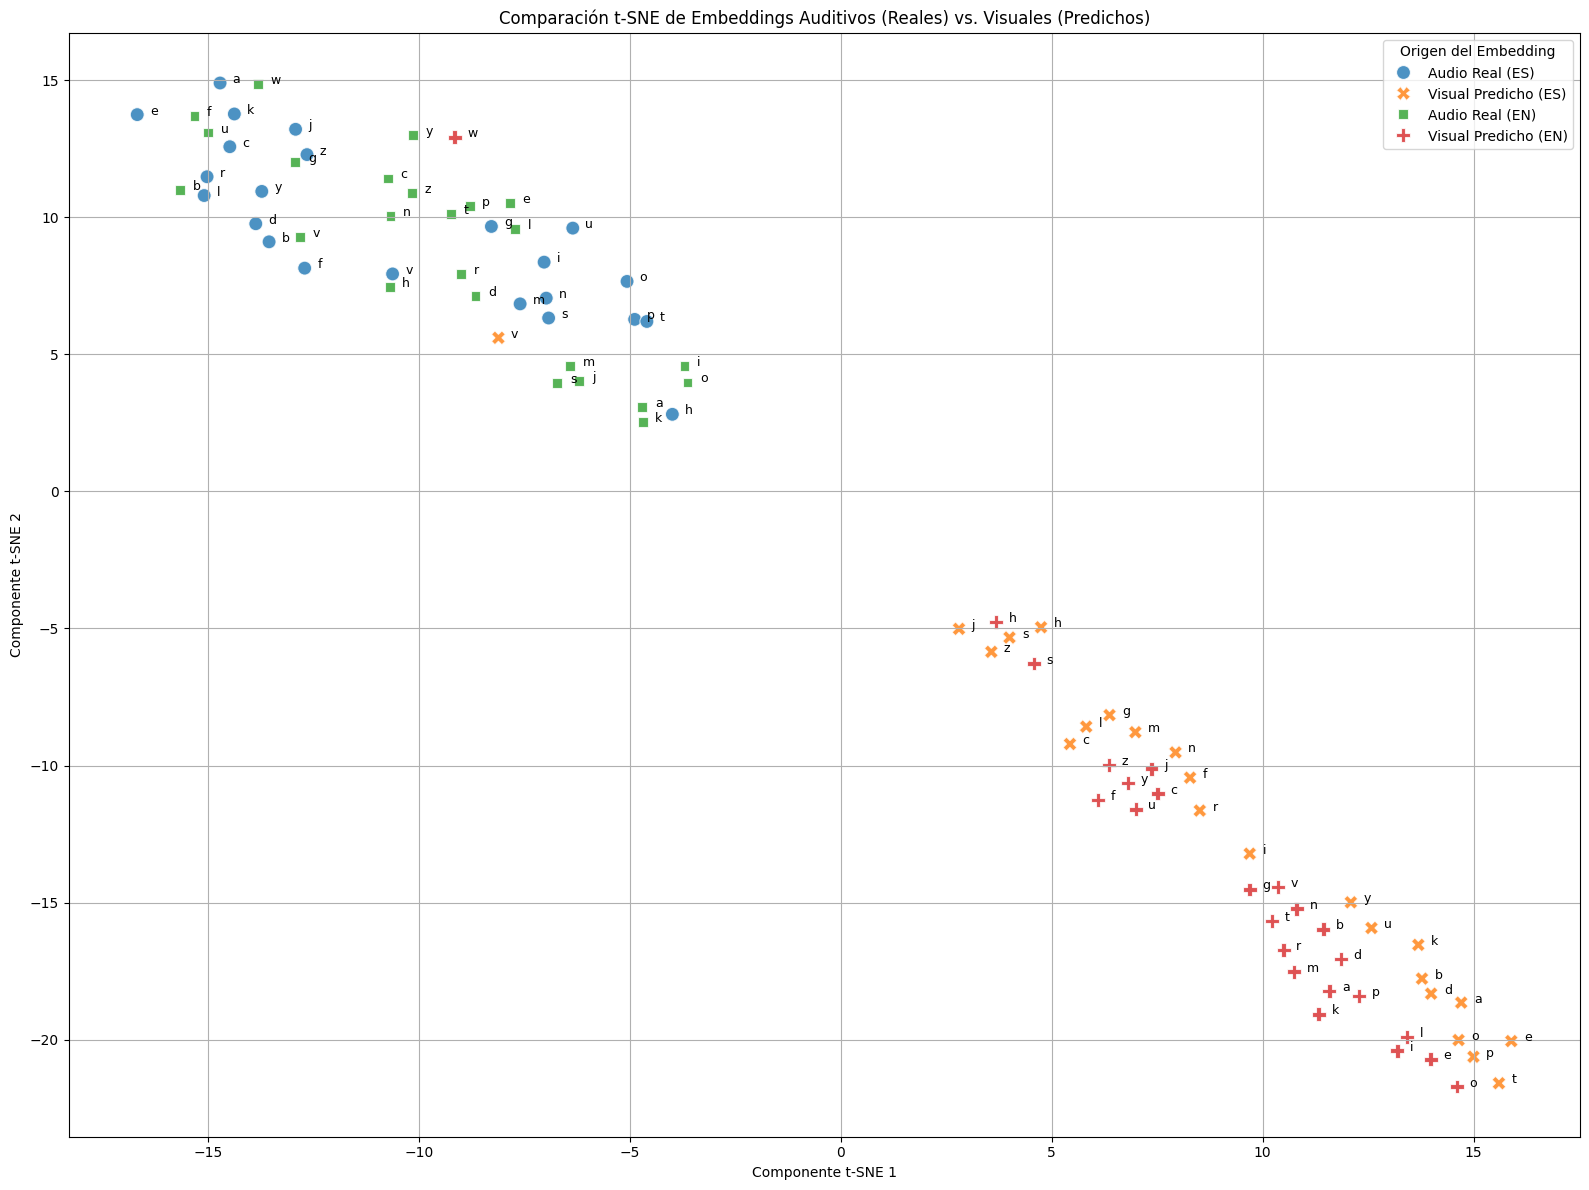

Gráfico t-SNE comparativo guardado en: /home/daniel/Proyectos/phonological-awareness/results/figures/auditory_vs_visual_tsne_comparison.png


In [6]:
from sklearn.manifold import TSNE

# --- Preparar datos para el gráfico fusionado ---
all_embeddings_avg = []
all_labels = []
all_sources = []

print("Preparando datos para la visualización t-SNE comparativa...")

for lang in LANGUAGES:
    # --- 1. Cargar embeddings REALES de la vía auditiva y promediarlos ---
    audio_embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    # Obtenemos solo los grafemas comunes que se usaron en el entrenamiento visual
    visual_dataset = GraphemeDataset(
        project_root / f"data/02_processed/grapheme_images/{lang}",
        audio_embedding_dir
    )
    # Creamos un set de los grafemas para una búsqueda rápida
    common_graphemes = {p.parent.name for p in visual_dataset.image_paths}
    
    for label in sorted(list(common_graphemes)):
        embedding_seq = np.load(audio_embedding_dir / f"{label}.npy")
        all_embeddings_avg.append(embedding_seq.mean(axis=0))
        all_labels.append(label)
        all_sources.append(f'Audio Real ({lang.upper()})')
        
    # --- 2. Generar embeddings PREDICHOS de la vía visual y promediarlos ---
    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    # Usamos el dataset de validación para generar las predicciones
    val_dataset_lang = results_visual[lang]['val_dataset']
    val_loader_lang = DataLoader(val_dataset_lang, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)
    
    # Diccionario para agrupar predicciones por etiqueta
    predictions_by_label = {label: [] for label in common_graphemes}

    with torch.no_grad():
        for i, (images, target_embeddings) in enumerate(val_loader_lang):
            # Para obtener la etiqueta, necesitamos acceder al dataset original
            start_idx = i * BATCH_SIZE
            batch_labels = [val_dataset_lang.dataset.image_paths[idx].parent.name for idx in val_dataset_lang.indices[start_idx:start_idx+len(images)]]

            predicted_seqs = visual_model(images.to(device), target_embeddings.to(device))
            predicted_avg = predicted_seqs.mean(dim=1).cpu().numpy()
            
            for j, label in enumerate(batch_labels):
                predictions_by_label[label].append(predicted_avg[j])

    # Promediar las predicciones para cada grafema
    for label in sorted(list(common_graphemes)):
        if predictions_by_label[label]:
            avg_pred = np.mean(predictions_by_label[label], axis=0)
            all_embeddings_avg.append(avg_pred)
            all_labels.append(label)
            all_sources.append(f'Visual Predicho ({lang.upper()})')

# --- Calcular y Graficar t-SNE ---
embedding_matrix_combined = np.array(all_embeddings_avg)
print("\nCalculando proyección t-SNE para todos los embeddings... Esto puede tardar.")
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embedding_matrix_combined)

tsne_df = pd.DataFrame({
    'tsne-1': embeddings_2d[:, 0],
    'tsne-2': embeddings_2d[:, 1],
    'grapheme': all_labels,
    'source': all_sources
})

# --- Graficar ---
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="source",
    style="source",
    data=tsne_df,
    s=100, # Tamaño de los puntos
    alpha=0.8
)

# Añadir anotaciones para identificar los grafemas
for i, row in tsne_df.iterrows():
    plt.text(row['tsne-1']+0.3, row['tsne-2'], row['grapheme'], fontsize=9)

plt.title('Comparación t-SNE de Embeddings Auditivos (Reales) vs. Visuales (Predichos)')
plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2'); plt.grid(True)
plt.legend(title='Origen del Embedding')
plt.tight_layout()

# Guardar la figura final
tsne_comparison_path = figure_dir / "auditory_vs_visual_tsne_comparison.png"
plt.savefig(tsne_comparison_path)
plt.show()

print(f"Gráfico t-SNE comparativo guardado en: {tsne_comparison_path}")

## Paso 4: Evaluación Comparativa Final (Vía Visual vs. Vía Auditiva)

Este es el experimento culminante del proyecto. Comparamos directamente el rendimiento del **clasificador auditivo** bajo dos condiciones:
1.  **Condición Auditiva (Original)**: Cuando recibe como entrada los embeddings reales extraídos del audio.
2.  **Condición Visual (Cruzada)**: Cuando recibe como entrada los embeddings "imaginados" que nuestro modelo visual predijo a partir de imágenes.

Analizamos esta comparación a través de dos métricas clave:
-   **Matriz de Confusión**: Muestra las decisiones finales de clasificación (aciertos y errores).
-   **Heatmap de Logits**: Muestra la "confianza" o la puntuación que el clasificador asigna a cada posible fonema antes de tomar la decisión final.

Una alta similitud entre las matrices y los heatmaps de ambas vías indicaría que nuestro modelo visual ha aprendido a generar representaciones auditivas de alta fidelidad.


--- Evaluación Cruzada para: ES ---

--- Evaluación Cruzada para: EN ---


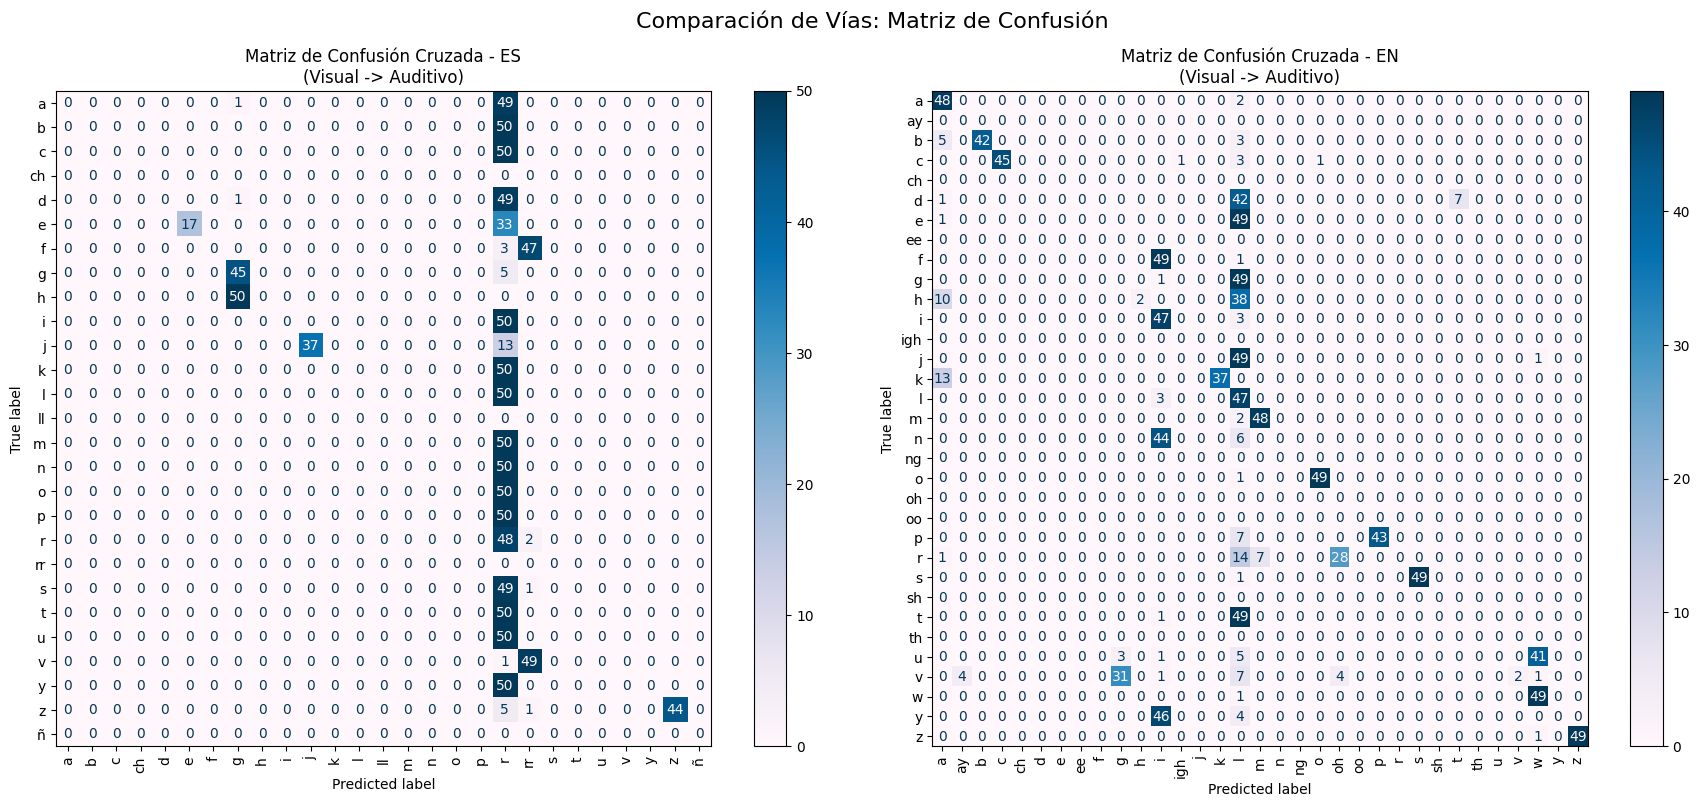

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- 1. Modificar el Dataset para que devuelva la etiqueta de texto ---
class GraphemeDataset(Dataset):
    def __init__(self, image_dir, embedding_dir, transform=None):
        self.transform = transform
        self.embedding_dir = embedding_dir
        image_graphemes = {p.parent.name for p in image_dir.glob("*/*.png")}
        embedding_graphemes = {p.stem for p in embedding_dir.glob("*.npy")}
        common_graphemes = sorted(list(image_graphemes.intersection(embedding_graphemes)))
        self.image_paths = []
        for grapheme in common_graphemes:
            self.image_paths.extend(list((image_dir / grapheme).glob("*.png")))
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_text = img_path.parent.name # <-- Devolvemos la etiqueta de texto
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        embedding_path = self.embedding_dir / f"{label_text}.npy"
        embedding = torch.tensor(np.load(embedding_path), dtype=torch.float32)
        return image, embedding, label_text # <-- Nueva salida

# Modificamos la collate_fn para manejar la nueva salida
def collate_fn_visual_with_labels(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    labels_text = [item[2] for item in batch] # <-- Recolectamos las etiquetas de texto
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings, labels_text # <-- Nueva salida

# --- 2. Definir la arquitectura de la CNN Auditiva (del Cuaderno 02) ---
class PhonemeCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PhonemeCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128); self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256); self.fc = nn.Linear(256, num_classes)
    def forward(self, x):
        x = x.transpose(1, 2); x = F.relu(self.bn1(self.conv1(x))); x = F.relu(self.bn2(self.conv2(x)))
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1); x = self.fc(x); return x

# --- 3. Bucle de Evaluación Cruzada ---
fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(18, 8))
if len(LANGUAGES) == 1: axes = [axes]

for i, lang in enumerate(LANGUAGES):
    ax = axes[i]
    print(f"\n--- Evaluación Cruzada para: {lang.upper()} ---")
    
    # Cargar el clasificador auditivo entrenado
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    if not auditory_model_path.exists():
        ax.text(0.5, 0.5, f"Modelo auditivo para '{lang}' no encontrado.", ha='center'); ax.set_title(f"Error - {lang.upper()}"); continue
        
    audio_embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    auditory_labels = sorted([p.stem for p in audio_embedding_dir.glob("*.npy")])
    num_auditory_classes = len(auditory_labels)
    auditory_label_to_int = {label: i for i, label in enumerate(auditory_labels)}
    auditory_int_to_label = {i: label for label, i in auditory_label_to_int.items()}

    auditory_cnn = PhonemeCNN(input_size=1024, num_classes=num_auditory_classes).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()

    # Cargar el modelo visual entrenado
    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    # Crear un DataLoader con el Dataset modificado
    image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    full_dataset_lang = GraphemeDataset(image_dir, audio_embedding_dir, transform=transform)
    # Usaremos todo el dataset para la evaluación final
    loader_lang = DataLoader(full_dataset_lang, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual_with_labels)
    
    all_true_labels_indices = []
    all_predicted_labels_indices = []
    
    with torch.no_grad():
        for images, target_embeddings, true_labels_text in loader_lang:
            images, target_embeddings = images.to(device), target_embeddings.to(device)
            predicted_embeddings = visual_model(images, target_embeddings)
            outputs = auditory_cnn(predicted_embeddings)
            _, predicted_indices = torch.max(outputs.data, 1)
            
            true_indices = torch.tensor([auditory_label_to_int.get(lbl, -1) for lbl in true_labels_text], dtype=torch.long)
            # Filtrar etiquetas que no estaban en el entrenamiento del modelo auditivo (ej. 'ñ')
            mask = true_indices != -1
            
            all_true_labels_indices.extend(true_indices[mask].cpu().numpy())
            all_predicted_labels_indices.extend(predicted_indices[mask].cpu().numpy())

    # Generar y Graficar Matriz de Confusión Cruzada
    cm = confusion_matrix(all_true_labels_indices, all_predicted_labels_indices, labels=range(len(auditory_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=auditory_labels)
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='PuBu')
    ax.set_title(f'Matriz de Confusión Cruzada - {lang.upper()}\n(Visual -> Auditivo)')

fig.suptitle('Comparación de Vías: Matriz de Confusión', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(figure_dir / "cross_modal_confusion_matrix_comparison.png")
plt.show()